## Modelling Competence using Gaussian Smoothing

Last updated: 20 July 2022 by Julia Suter

### Structure of Notebook<a id='top'></a>

[**Why Gaussian Smoothing**](why)

[**Loading and Preparing the Data**](#loading)
- [Loading the data](#loading_data)
- [Preparing features](#prep)

[**Gaussian Smoothing**](#gaussian)
- [Flipping labels](#histo)
- [Feature space before and after Gaussian smoothing](#feat_space)
- [Gaussian Smoothing vs. Logistic Regression](#preds)



### Why Gaussian Smoothing<a id='why'></a>

We hope to identify the properties with a high potential for upgrades, meaning those that have not been upgraded yet but are very similar to those that have been. When looking at the feature space in the graphic below, we would like to find a barrier that splits the samples at the blue line.

However, our upgradability model is based on observed upgrades and recommendations, which represents the _performance upgradability_ of a property, but not its competence. A predictive model will try to find a barrier between properties with actual upgrades and those without (purple line), so a 'perfect' model will not give us the information we actually need.

More information can be found in this [slide deck](https://docs.google.com/presentation/d/1lcK895k0re_TpbtdKXe3jmRwj-dXGvQBkNsTaKxL2cU/edit?usp=sharing).

<br>
<br>
<div>
<img src="https://user-images.githubusercontent.com/42718928/179941097-d1314c7b-c4dd-4ca5-bebb-f7deea98d58e.png" width="550"/>
</div>



This notebook demonstrates an attempt of modelling 'competence' using Gaussian smoothing, which gives less weight to the absolute position of a sample in the feature space and instead focuses on its neighbours. The original label of each sample is smoothed by integrating information about how many neighbours have had upgrades, weighted by their distance to the samples.

This analysis is supposed to identify whether there is a signifant gap between performance and competence, i.e. the respective models for them. The logistic regression model represents the performance, the Gaussian smoothing model represents the competenence.

<br>
<br>
<div>
<img src="https://user-images.githubusercontent.com/42718928/179941065-9b11427a-597a-4612-a703-0cf4c4b3f9d8.png" width="550"/>
</div>

## Loading and preparing the data<a id='loading'></a>
[[back to top]](#top)

In [90]:
%load_ext autoreload
%autoreload 2

import pandas as pd


from development_bank_wales import PROJECT_DIR, Path

from development_bank_wales.pipeline.feature_preparation import (
    recommendations,
    feature_engineering,
)

from development_bank_wales.pipeline.predictive_model import (
    model_preparation,
    plotting,
    evaluation,
    training,
    gaussian_smoothing,
)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import numpy as np
import scipy

import matplotlib.pyplot as plt

plt.style.use("default")
plt.style.use("seaborn")
%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5)


import warnings
warnings.simplefilter(action="ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the data<a id='loading_data'></a>
[[back to top]](#top)

When executed the very first time, the EPC data is loaded from S3 and saved in `/outputs/data/`. This takes about 5min. After that, the data will be loaded from the local directory (<30 secs).

In [91]:
output_path = PROJECT_DIR / "outputs/data/wales_epc_with_recs.csv"
fig_output_path = PROJECT_DIR / "outputs/figures/"

if not Path(output_path).is_file():

    print("Loading and preparing the data...")

    wales_df = recommendations.load_epc_certs_and_recs(
        data_path="S3", subset="Wales", n_samples=None, remove_duplicates=False
    )

    wales_df.to_csv(output_path, index=False)

    print("Done!")

else:

    print("Loading the data...")
    wales_df = pd.read_csv(output_path)
    print("Done!")

Loading the data...
Done!


### Prepare features<a id='prep'></a>
[[back to top]](#top)

We clean the description features, reduce the set to owner-occupied properties and retrieve information about upgrades and upgradability scores for the different categories.

We pass the features through the preparation pipeline that handles the following:
- sample balancing
- feature selection (given specific label)
- feature encoding
- imputing
- scaling
- if needed: principal component analysis

Finally, we get a test and train split for evaluation.


In [92]:
wales_df = feature_engineering.get_upgrade_features(wales_df)

label = "ROOF_UPGRADABILITY"
features, labels, feature_list = model_preparation.feature_prep_pipeline(
    wales_df, label
)


In [93]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=42, stratify=labels
)

print("Training Features Shape:", train_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Features Shape:", test_features.shape)
print("Testing Labels Shape:", test_labels.shape)

Training Features Shape: (391898, 131)
Training Labels Shape: (391898,)
Testing Features Shape: (130633, 131)
Testing Labels Shape: (130633,)


## Gaussian smoothing<a id='gaussian'></a>
[[back to top]](#top)

Apply gaussian smoothing to the original labels. As a sanity check, test whether a set of properties with an original 'True' label end up on the higher uprgradability side of the distribution if they are flipped to False and put through Gaussian smoothing. This shows that a False label can be "corrected" if a property is close to upgraded properties in the feature space.

In [94]:
n_samples = 10000

smoothed_labels, org_labels, _ = gaussian_smoothing.get_smoothed_labels(
    test_features, test_labels, n_samples=n_samples, flip_indices=False, random_state=42
)
sm_labels_flp, labels_flp, flp_idx = gaussian_smoothing.get_smoothed_labels(
    test_features, test_labels, n_samples=n_samples, flip_indices=True, random_state=42
)

### Flipping labels<a id='histo'></a>
[[back to top]](#top)

When looking at the properties originally labeled as 'not upgradable', we see that there seems to be a split of the data into two peaks (around 0.27). We expect that most properties with flipped labels (from True to False) will come out at the second peak (higher ugradability) of the distribution, proving that Gaussian smoothing can raise the upgradability score of a "non upgradable" property that is very similar to the upgraded ones.

We evaluate by flipping 5 different sets of 100 samples. On average, 68.8% of the flipped samples end up in the top third of upgradable properties.

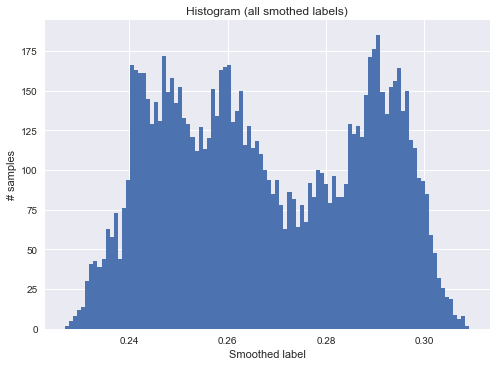

In [95]:
plt.hist(smoothed_labels, bins=100)

plt.ylabel("# samples")
plt.xlabel("Smoothed label")
plt.tight_layout()
plt.title("Histogram (all smothed labels)")
plt.savefig(fig_output_path / "Histogram_all_smoothed_labels.png")
plt.show()

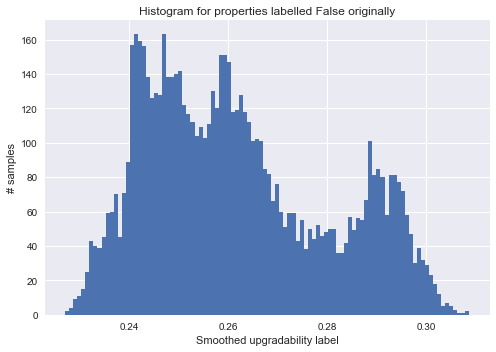

In [96]:
upgradables = smoothed_labels[~org_labels.astype(bool)]

plt.hist(upgradables, bins=100)

plt.title("Histogram for properties labelled False originally")
plt.ylabel("# samples")
plt.xlabel("Smoothed upgradability label")
plt.tight_layout()
plt.savefig(fig_output_path / "Histogram_only_False_labelled.png")
plt.show()

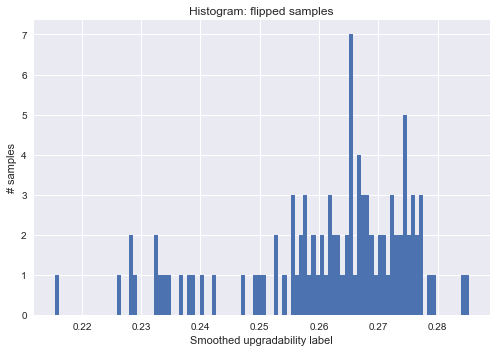

In [97]:
sm_labels_flp, _, flp_idx = gaussian_smoothing.get_smoothed_labels(
    test_features, test_labels, n_samples=n_samples, flip_indices=True, random_state=42
)

plt.hist(sm_labels_flp[flp_idx], bins=100)
plt.title("Histogram: flipped samples")
plt.ylabel("# samples")
plt.xlabel("Smoothed upgradability label")
plt.tight_layout()
plt.savefig(fig_output_path / "Histogram_flipped_samples.png")
plt.show()

In [98]:
high_upr_ratios = []
percentile = 66

for i in range(5):

    sm_labels_flp, _, flp_idx = gaussian_smoothing.get_smoothed_labels(
        test_features, test_labels, n_samples=n_samples, flip_indices=True, random_state=i
    )

    high_upr_ratio = sm_labels_flp[flp_idx] > np.percentile(
        sm_labels_flp, percentile)
    high_upr_ratio = high_upr_ratio.sum() / high_upr_ratio.shape[0] * 100

    print(
        "{}) Flipped samples that come out in top third? {}%".format(
            i + 1, high_upr_ratio
        )
    )

    high_upr_ratios.append(high_upr_ratio)

print(
    "\nFlipped samples that come out in top third? Average: {:1.1f}%".format(
        sum(high_upr_ratios) / len(high_upr_ratios)
    )
)

1) Flipped samples that come out in top third? 77.0%
2) Flipped samples that come out in top third? 68.0%
3) Flipped samples that come out in top third? 67.0%
4) Flipped samples that come out in top third? 65.0%
5) Flipped samples that come out in top third? 67.0%

Flipped samples that come out in top third? Average: 68.8%


### Feature space before and after Gaussian smoothing<a id='feat_space'></a>
[[back to top]](#top)


These t-SNE plots represent the feature space of the properties. The first plot shows the orignal labels of the samples. The 'non-upgradable' properties are clustered together.

The left part of the second plot shows the smoothed upgradability labels for samples that originally were labeled as 'non-upgradable'. The brigher the colour, the higher the upgradability. The right part shows the distribution of the subset of the flipped samples after Gaussian smoothing. Most show relatively high upgradability and fall within the (yellow) area (first plot) of upgradable properties. 

This shows that the Gaussian smoothing correctly gives high upgradability scores to properties with features similar to other upgradable properties, even if their original label is 'non-upgradable'. The Gaussian smoothed label captures competence better than the original label, which represents performance.

In [99]:
smoothed_labels, org_labels, _  = gaussian_smoothing.get_smoothed_labels(
    test_features, test_labels, n_samples=n_samples, flip_indices=False, random_state=42
)
sm_labels_flp, _, flp_idx = gaussian_smoothing.get_smoothed_labels(
    test_features, test_labels, n_samples=n_samples, flip_indices=True, random_state=42
)

tsne = TSNE()
test_tsne = tsne.fit_transform(test_features[:n_samples])

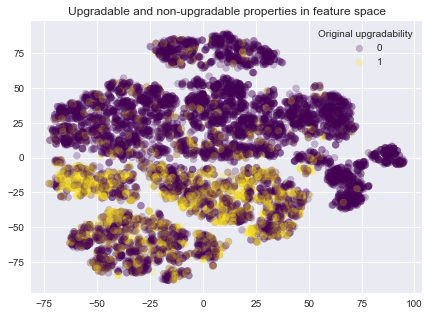

In [100]:
scatter = plt.scatter(
    test_tsne[:, 0], test_tsne[:, 1], c=org_labels, cmap="viridis", alpha=0.25
)
plt.title("Upgradable and non-upgradable properties in feature space")

plt.legend(
    handles=scatter.legend_elements()[0],
    labels=["0", "1"],
    title="Original upgradability",
)
plt.savefig(fig_output_path / "Feature_space_labes.png")

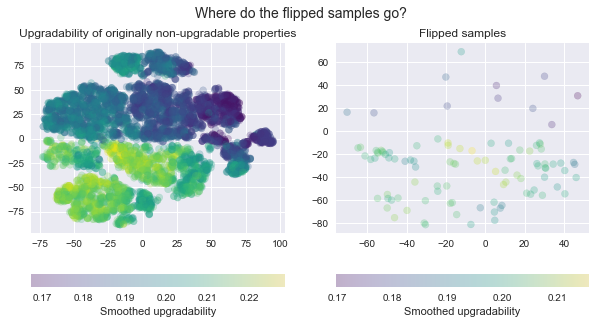

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
plt.subplot(1, 2, 1,)

scatter = plt.scatter(
    test_tsne[~org_labels.astype(bool).flatten(), 0],
    test_tsne[~org_labels.astype(bool).flatten(), 1],
    c=smoothed_labels[~org_labels.astype(bool).flatten()],
    alpha=0.25,
    cmap="viridis",
)

plt.colorbar(label="Smoothed upgradability", orientation="horizontal")
plt.title("Upgradability of originally non-upgradable properties")

plt.subplot(1, 2, 2) # index 2
plt.scatter(
    test_tsne[flp_idx, 0],
    test_tsne[flp_idx, 1],
    c=sm_labels_flp[flp_idx],
    alpha=0.25,
    cmap="viridis",
)

plt.colorbar(label="Smoothed upgradability", orientation="horizontal")
plt.title("Flipped samples")

fig.suptitle('Where do the flipped samples go?', fontsize=14)
fig.savefig(fig_output_path / "Feature_space_flipped_samples.png")

### Gaussian Smoothing vs. Logistic Regression<a id='preds'></a>
[[back to top]](#top)


Gaussian smoothing is not ideal for predicting the upgradability of new samples as it is an unsupervised model. However, we can compare the Gaussian labels to the output of a predictive model (Logistic regression) to study the difference between competence and performance. 

To imitiate 'Gaussian predictions', we consider the top 25% of all properties with highest upgradability "upgradable", no matter the original label. That approach yields an accuracy of 76% compared to 82% with logistic regression model, meaning that there is a clear difference between the two models. 

The overlap between Gaussian predictions and the logistic regression predictions is fairly high with 81.5%. Even the overlap of the two predictions with the labels is 70.3%, which suggests that the difference between competence and performance - while detectable - does not necessarily have a large impact.

While further research is required (for example, repetition of this experiment with other labels, e.g. WALLS_UPGRADABILITY) and in-depth qualitative evaluation and comparison might reveal interesting aspects of the competence and performance model, we assume that the detected gap between the two models is not significant enough to make us question the suitablity of the logistic regression model for predicting upgradability.

<br>
<br>
<div>
<img src="https://user-images.githubusercontent.com/42718928/179942821-d019dd6e-5968-4356-8a3a-a27e3c19701b.png" width="450"/>
</div>

In [102]:
smooth_predictions = (smoothed_labels > np.percentile(smoothed_labels, 75)).astype(int)

evaluation.print_metrics(test_labels[:n_samples], smooth_predictions[:n_samples])

Accuracy:	76.44%
F1 score:	46.21%
Recall:		40.48%
Precision:	53.83%


In [103]:
model = training.model_dict["Logistic Regression"]
model.fit(train_features, train_labels)

y_pred_test = model.predict(test_features)
y_pred_train = model.predict(train_features)
evaluation.print_metrics(test_labels[:n_samples], y_pred_test[:n_samples])

Accuracy:	82.78%
F1 score:	58.47%
Recall:		53.49%
Precision:	64.47%


In [104]:
gaussian_preds = smooth_predictions.flatten()[:n_samples]
log_regression_preds = y_pred_test[:n_samples]
org_upgr_labels = test_labels[:n_samples]

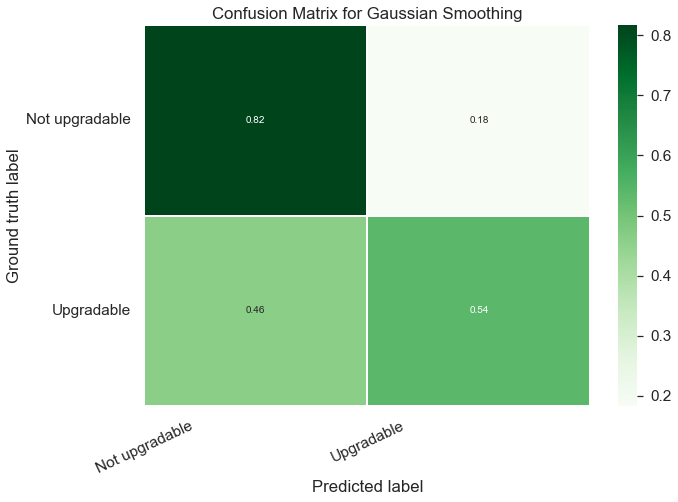

In [105]:
plotting.plot_confusion_matrix(
    org_upgr_labels,
    gaussian_preds,
    label_set=["Not upgradable", "Upgradable"],
    title="Gaussian Smoothing",
    plot_type="seaborn",
)

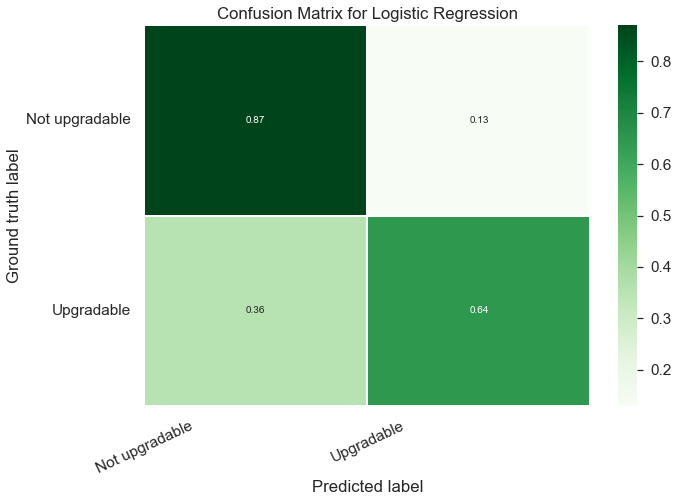

In [106]:
plotting.plot_confusion_matrix(
    org_upgr_labels,
    log_regression_preds,
    label_set=["Not upgradable", "Upgradable"],
    title="Logistic Regression",
    plot_type="seaborn",
)

In [107]:
smooth_log_comp = gaussian_preds == log_regression_preds
ratio = smooth_log_comp.sum() / smooth_log_comp.shape[0] * 100
print(
    "Overlap of smoothed labels and logistic regression predictions: {:0.1f}%".format(
        ratio
    )
)

Overlap of smoothed labels and logistic regression predictions: 81.5%


In [108]:
smooth_label_comp = gaussian_preds == org_upgr_labels
ratio = smooth_label_comp.sum() / smooth_label_comp.shape[0] * 100
print("Overlap of smoothed labels and labels (accuracy): {:0.1f}%".format(ratio))

Overlap of smoothed labels and labels (accuracy): 76.4%


In [109]:
log_label_comp = log_regression_preds == org_upgr_labels
ratio = log_label_comp.sum() / log_label_comp.shape[0] * 100
print("Overlap of logistic regression predictions and labels (accuracy): {:0.1f}%".format(ratio))

Overlap of logistic regression predictions and labels (accuracy): 82.8%


In [110]:
smooth_log_label_comp = (gaussian_preds == org_upgr_labels) & (log_regression_preds == org_upgr_labels)
ratio = smooth_log_label_comp.sum() / smooth_log_label_comp.shape[0] * 100
print(
    "Overlap of smoothed labels and logistic regression predictions and labels: {:0.1f}%".format(
        ratio
    )
)

Overlap of smoothed labels and logistic regression predictions and labels: 70.3%
